### 7.1 투표 기반 분류기

- 직접 투표(hard voting) : 다수결 투표로 정해지는 분류기
- 간접 투표(soft voting) : 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측

- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘함. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높아 앙상블 모델의 정확도를 향상시킨다.

In [59]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# moons 데이터셋
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.3, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# solver : 최적화에 사용할 알고리즘
#   1) liblinear : L1, L2 제약조건 두 가지를 모두 지원. 작은 데이터에 적합한 알고리즘
#   2) sag, saga : 확률적경사하강법을 기반으로 함. 대용량 데이터에 적합한 알고리즘.
#                  sag는 L1, saga는 L1, L2 제약조건을 지원함.
#   3) newton-cg, lbfgs (sag, saga) : 멀티클래스 분류 모델에 사용.
#                  현재까지는 이 중에서 lbfgs 알고리즘이 가장 성능이 좋다고 알려짐.
log_clf = LogisticRegression(solver = "lbfgs", random_state = 42) 
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", random_state = 42)

# voting = 'hard' : 직접 투표
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                             voting = 'hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [10]:
# 간접 투표
log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", probability = True, random_state = 42)

voting_clf = VotingClassifier(estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc',svm_clf)],
                             voting = 'soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__ , accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### 7.2 배깅과 페이스팅

- 다양한 분류기를 만드는 또 다른 방법은 각기 다른 훈련알고리즘을 사용하는 것
- 배깅(bagging) : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅(pasting) : 중복을 허용하지 않고 샘플링하는 방식
- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.

#### 7.2.1 사이킷런의 배깅과 페이스팅

- 배깅과 페이스팅

부트스프래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들지만, 시간적 컴퓨터 자원적 여유가 된다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋다.

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 배깅
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(), n_estimators = 500,
                max_samples= 100, bootstrap = True, random_state = 42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [14]:
# 의사결정 나무
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


#### 7.2.2 OOB 평가

- oob(out-of-bag) 샘플 : 훈련에 사용되지 않은 샘플
- 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다.

In [15]:
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators = 500,
        bootstrap=True, oob_score = True, random_state = 42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [16]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.35625   , 0.64375   ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97409326, 0.02590674],
       [0.7370892 , 0.2629108 ],
       [0.0049505 , 0.9950495 ],
       [0.75      , 0.25      ],
       [0.82681564, 0.17318436],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.34502924, 0.65497076],
       [0.91666667, 0.08333333],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65420561, 0.34579439],
       [0.

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

### 7.3 랜덤 패치와 랜덤 서브스페이스

- max_features, bootstrap_features : 특성에 대한 샘플링
- max_samples, bootstrap : 샘플에 대한 샘플링

- 랜덤 패치 방식(random patched method): 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식(random subspaces method): 훈련 샘플을 모두 사용하고, 특성은 샘플링 하는 것.

### 7.4 랜덤 포레스트

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, random_state = 42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [20]:
# BaggingClassifier로 위의 랜덤 포레스트 구현
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
                n_estimators = 500, random_state = 42)

In [21]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [22]:
# 랜덤 포레스트 정확도
accuracy_score(y_test, y_pred_rf)

0.912

In [23]:
# 배깅 정확도
accuracy_score(y_test, y_pred)

0.912

In [24]:
# 둘의 예측이 거의 동일하다
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

#### 7.4.2 특성 중요도

In [25]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


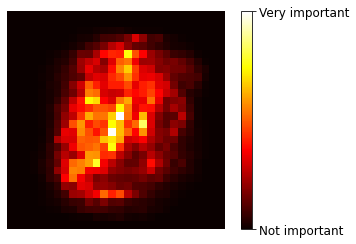

In [28]:
# 랜덤 포레스트 분류기에서 얻은 MNIST 픽셀 중요도
from sklearn.datasets import fetch_openml

# 데이터 불러오기
mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

# 랜덤포레스트 모델 적합
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rnd_clf.fit(mnist["data"], mnist["target"])

# 그래프 그리는 함수
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation= "nearest")
    plt.axis('off')
    
# 그래프 그리기
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

### 7.5 부스팅

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법, 앞의 모델을 보완해 나가면서 학습시킴.

#### 7.5.1 에이다 부스트

- 오분류된 샘플에 대해 가중치를 부여하는 방식
- p.258 ~ p.261

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators = 200,
        algorithm = "SAMME.R", learning_rate = 0.5, random_state = 42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                    learning_rate=0.5, n_estimators=200, random_state=42)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [32]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

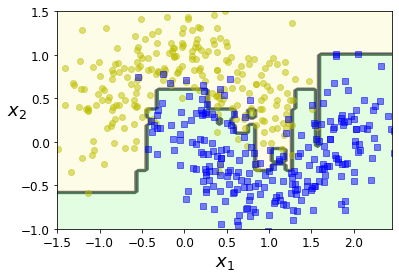

In [33]:
plot_decision_boundary(ada_clf, X, y)

#### 7.5.2 그래이디언트 부스팅

- gradient boosting : 이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습시킴.

In [34]:
# 데이터 생성
np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [37]:
# decisiontree로 구현
from sklearn.tree import DecisionTreeRegressor

# 첫번째 예측기 훈련
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# 두번째 예측기 훈련
y2 = y - tree_reg1.predict(X) # 잔여 오차
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

# 세번째 예측기 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [41]:
# 0.8 에 대한 예측값
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [45]:
# 그래이디어트 부스팅 회귀 나무로 모델 생성
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:
# 조기 종료를 사용한 그래디언트 부스팅

# 가장 낮은 검증 오류를 가질 때 종료
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
            for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators = bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=118,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [57]:
min_error = np.min(errors)

In [61]:
# 어느 정도 유예를 갖는 조기 종료 (5 에포크 동안 향상되지 않을 때만 훈련 중지)

# warm_start = Tree : 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다.

gbrt = GradientBoostingRegressor(max_depth=2, warm_start = True, random_state=42)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up +=1
        if error_going_up == 5:
            break # 조기 종료
            

In [62]:
print(gbrt.n_estimators)

105


In [63]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.003023701609089896


- 확률적 그래디언트 부스팅(stochastic gradient boosting)

각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subample 매개변수 지원. 편향이 높아지는 대신 분산이 낮아지고 훈련 속도가 빨라진다.

#### XGBoost

In [65]:
#!pip install xgboost

In [66]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [67]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

Validation MSE: 0.0030701301701716146


In [68]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[0]	validation_0-rmse:0.19678
[1]	validation_0-rmse:0.14325
[2]	validation_0-rmse:0.10835
[3]	validation_0-rmse:0.08482
[4]	validation_0-rmse:0.07044
[5]	validation_0-rmse:0.06255
[6]	validation_0-rmse:0.05927
[7]	validation_0-rmse:0.05698
[8]	validation_0-rmse:0.05519
[9]	validation_0-rmse:0.05513
[10]	validation_0-rmse:0.05473
[11]	validation_0-rmse:0.05463
[12]	validation_0-rmse:0.05427
[13]	validation_0-rmse:0.05376
[14]	validation_0-rmse:0.05377
[15]	validation_0-rmse:0.05363
[16]	validation_0-rmse:0.05358
[17]	validation_0-rmse:0.05387
[18]	validation_0-rmse:0.05386
Validation MSE: 0.0028706534131390338


### 7.6 스태킹 (stacking)

### 7.7 연습문제

1. 정확히 같은 훈련 데이터로 다섯 개의 다른 모델을 훈련시켜서 모두 95% 정확도를 얻었다면 이 모델들을 연결하여 더 좋은 결과를 얻을 수 있을까요? 가능하다면 어떻게 해야 할까요? 그렇지 않다면 어떻게 해야할까요? 

- 다섯 개의 모델을 훈련시켰고 모두 95%의 정확도를 달성했다면 이를 연결하여 투표 앙상블 모델을 만들어 더 나은 결과를 기대해 볼 수 있다. 만약 모델이 서로 다르다면 훨ㅆㄴ 좋고(SVM, 결정 트리 분류기, 로지스틱 회귀 분류기 등), 다른 훈련 샘플에서 훈련되었다면 더더욱 좋다 (배깅, 페이스팅) 하지만 그렇지 않더라도 모델이 서로 많이 다르다면 더 좋은 결과를 기대할 수 있다.

2. 직접 투표와 간접 투표 분류기 사이의 차이점으 무엇일까요?

- 직접 투표 분류기는 앙상블에 있는 각 분류기의 선택을 카운트하여 가장 많은 투표를 얻은 클래스를 선택한다. 간접 투표 분류기는 각 클래스의 평균적인 확률 추정값을 계산하여 가장 높은 확률을 가진 클래스를 고른다. 간접 투표 분류기 방식은 신뢰가 높은 투표에 더 가중치를 주고 종종 더 나은 성능을 보이기도 한다. 하지만 모든 분류기가 클래스 확률을 추정할 수 있어야 사용할 수 있다. (사이킷런의 SVM 분류기는 probability = True로 지정해야 확률 추정값을 얻을 수 있다.)

3. 배깅 앙상블의 훈련을 여러 대의 서버에 분산시켜 속도를 높일 수 있는가? 페이스팅 앙상블, 부스팅 앙상블, 랜덤 포레스트, 스태킹 앙상블의 경우는 어떠한가?

- 가능한 방식 : 배깅, 페이스팅, 랜덤 포레스트, 경우에 따라 스태킹
- 불가능한 방식: 부스팅, 경우에 따라 스태킹 

- 배깅, 페이스팅, 랜덤 포레스트 앙상블의 경우 각 예측기는 독립적이기 때문에 여러 대의 서버에 분산하여 앙상블의 훈련 속도를 높일 수 있다. 그러나 부스팅 앙상블의 예측기는 이전 예측기를 기반으로 만들어지므로 훈련이 순차적이어야하고 여러 대의 서버에 분산해서 얻을 수 있는 이득이 없다. 스태킹 앙상블의 경우 한 층의 모든 예측기가 각각 독립적이므로 여러 대의 서버에서 병렬로 훈련할 수 있다. 하지만 한 층에 있는 예측기들은 이전 층의 예측기들이 훈련된 후에 훈련될 수 있다.

4. oob 평가의 장점은 무엇인가?

- oob 평가를 사용하면 배깅 앙상블의 가 예측기가 훈련에 포함되지 않은 샘플을 사용함. 이 때문에 추가적인 검증 세트가 없어도 편향되지 않게 모델의 성능을 측정할 수 있게 된다. 따라서 훈련에 더 많은 샘플을 사용할 수 있게 되므로 앙상블 학습기의 성능이 향상될 수 있다.

5. 무엇이 엑스트라 트리를 일반 랜덤 포레스트보다 더 무작위하게 만드는가? 추가적인 무작위성이 어떻게 도움이 되는가? 엑스트라 트리는 일반 랜덤 포레스트보다 느린가, 빠른가?

- 랜덤 포레스트에서 트리가 성장할 때 각 노드에서 특성의 일부를 무작위로 선택해 분할에 사용한다. 엑스트라 트리에서도 이는 마찬가지지만 한 단계 더 나아가서 일반 결정 트리처럼 가능한 최선의 임계점을 찾는 것이 아니라 각 특성에 대해 랜덤한 임계점을 사용한다.(임계점 선택마저 랜덤으로 선택한다) 이 추가적인 무작위성은 규제처럼 작동하게 된다. 랜덤 포레스트가 훈련 데이터에 과대적합되었다면 엑스트라 트리는 그렇지 않을 것이다. 또한, 엑스트라 트리는 가능한 최선이 임계점을 찾지 않기 때문에 랜덤 포레스트보다 훨씬 빠르게 훈련된다. 그러나 예측을 할 때는 랜덤포레스트와 비슷하다. 

6. 에이다부스트 앙상블이 훈련 데이터에 과소적합되었다면 어떤 매개변수를 어떻게 바꿔야 하는가?

- 예측기 수를 증가시키거나 기본 학습기의 규제 하이퍼파라미터를 감소시킨다. 학습률을 증가시켜볼 수 있다.

7. 그래디언트 부스팅 앙상블이 훈련 데이터에 과대적합되었다면 학습률을 높여야 하나, 낮춰야 하나?

- 학습률을 감소시켜야 한다. 알맞은 개수를 찾기 위해 조기 종료 기법을 사용할 수 있다.

8. MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눈다. (훈련 50000, 검증 10000, 테스트 10000) 그런 다음 랜덤포레스트, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킨다. 그리고 검증 세트에 대해 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결한다. 앙상블을 얻고난 뒤 테스트 세트로 확인해봐라. 개개의 분류기와 비교해서 성능이 얼마나 향상되는가?

In [3]:
# 데이터 불러오기 
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

In [5]:
# 데이터 분할
from sklearn.model_selection import train_test_split

# test set 10000개
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size =10000, random_state=42)

# train set 10000개
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [8]:
# 랜덤 포레스트
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# 엑스트라 트리
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state = 42)
# svm
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
#mlp : 다층신경망
mlp_clf = MLPClassifier(random_state=42)

In [9]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the ", estimator)
    estimator.fit(X_train, y_train)

Training the  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
               

In [10]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8495, 0.9626]

In [11]:
from sklearn.ensemble import VotingClassifier

In [12]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)
]

#### VotingClassifier
- estimator = ("이름", 훈련기 객체)
- set_params() : "이름"= None으로 지정하면 특정 예측기를 제외시킬 수 있다.

In [13]:
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [14]:
voting_clf.score(X_val, y_val)

0.9706

In [15]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

## svm의 성능이 낮다 

[0.9692, 0.9715, 0.8495, 0.9626]

In [16]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [18]:
voting_clf.estimators # 예측기 목록 업데이트

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fracti

In [19]:
voting_clf.estimators_ # 훈련된 예측기 목록 (업데이트 되지 않음)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs

In [20]:
del voting_clf.estimators_[2] # 훈련기 제거

In [21]:
voting_clf.score(X_val, y_val)

# svm을 제거했더니 성능이 향상됨

0.9733

In [22]:
# 간접 투표기 생성
voting_clf.voting = "soft" # 속성 변경
voting_clf.score(X_val, y_val) # 직접 투표가 성능이 더 좋다

0.9699

In [23]:
# 최종 모델(직접 투표) test세트에서 성능 측정
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9701

In [24]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9607]

9. 이전 연습문제에서의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어봐라. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스이다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 봐라. 테스트 세트에서 평가도 해라. 

In [26]:
# 검증세트에서의 예측
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [27]:
X_val_predictions # 새로운 input값

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [28]:
# 랜덤포레스트를 사용하여 블랜더 생성
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
rnd_forest_blender.oob_score_ # oob 확인

0.9678

In [30]:
# 테스트 세트에서 성능평가
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [31]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(y_test, y_pred)

0.9675